## Set Up

In [34]:
!pip install -r requirements.txt

In [35]:
%pip install python-gnupg
%pip install eep153_tools

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [36]:
import pandas as pd
import numpy as np
import cfe.regression as rgsn
from eep153_tools.sheets import read_sheets

## Data Loading

In [37]:
InputFiles = {'Expenditures':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2019-20)'),
              'Prices':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

In [38]:
# Get Expenditure data (2019-20)
x = read_sheets(InputFiles['Expenditures'][0], sheet=InputFiles['Expenditures'][1])
x.columns.name = 'j'
# x may have duplicate columns
x = x.T.groupby('j').sum().T
x = x.replace(0,np.nan) # Replace zeros with missing
# Take logs of expenditures; call this y
y = np.log(x.set_index(['i','t','m']))
#get hh household data
d = read_sheets(InputFiles['HH Characteristics'][0], sheet=InputFiles['HH Characteristics'][1])
d.columns.name = 'k'
d.set_index(['i','t','m'],inplace=True)
d['children_0413_size']=np.sum(d[['F 04-08', 'F 09-13', 'M 04-08', 'M 09-13']], axis=1)
####Aviod Multicollinearity
d=d.drop(['F 04-08', 'F 09-13', 'M 04-08', 'M 09-13'], axis=1)

# Get prices
p = read_sheets(InputFiles['Prices'][0],
                sheet=InputFiles['Prices'][1])
p = p.set_index(['t','m'])
p.columns.name = 'j'
p = p.xs('2019-20',level='t')
p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)



fct = read_sheets(InputFiles['FCT'][0],
                  sheet=InputFiles['FCT'][1])

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = read_sheets(InputFiles['RDI'][0],
                  sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

/tmp/ipykernel_369/2175215701.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x = x.replace(0,np.nan) # Replace zeros with missing


In [39]:
x.head()

j,Beans,Beef,Beer,Biscuits,Bongo,Bread,"Butter, etc.",Cabbages,Cake,Cassava,...,Tea,Tomatoes,Waragi,Water,Wheat (flour),Yam,Yogurt,i,m,t
0,3600.0,NaN,NaN,NaN,NaN,NaN,NaN,1400.0,NaN,6000.0,...,200.0,1000.0,NaN,NaN,NaN,3000.0,NaN,00c9353d8ebe42faabf5919b81d7fae7,Eastern,2019-20
1,NaN,NaN,NaN,NaN,NaN,500.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,062da72d5d3a457e9336b62c8bb9096d,Eastern,2019-20
2,1000.0,4500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,...,NaN,800.0,NaN,NaN,NaN,NaN,NaN,0d0e29faff394154a69562b4527b48b8,Eastern,2019-20
3,2800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3200.0,...,200.0,500.0,NaN,NaN,NaN,NaN,NaN,0e03e253c35d4333a1ffad2df9d38850,Eastern,2019-20
4,NaN,NaN,17500.0,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,...,400.0,2100.0,NaN,NaN,NaN,NaN,NaN,1013000201,Central,2019-20


In [40]:
y.head()

,,j,Beans,Beef,Beer,Biscuits,Bongo,Bread,"Butter, etc.",Cabbages,Cake,Cassava,...,Sugarcane,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi,Water,Wheat (flour),Yam,Yogurt
i,t,m,,,,,,,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,8.188689,NaN,NaN,NaN,NaN,NaN,NaN,7.244228,NaN,8.699515,...,NaN,NaN,8.294050,5.298317,6.907755,NaN,NaN,NaN,8.006368,NaN
062da72d5d3a457e9336b62c8bb9096d,2019-20,Eastern,NaN,NaN,NaN,NaN,NaN,6.214608,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,6.907755,8.411833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.294050,...,NaN,NaN,NaN,NaN,6.684612,NaN,NaN,NaN,NaN,NaN
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,7.937375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.070906,...,NaN,NaN,8.517193,5.298317,6.214608,NaN,NaN,NaN,NaN,NaN
1013000201,2019-20,Central,NaN,NaN,9.769956,NaN,NaN,NaN,NaN,NaN,NaN,8.294050,...,NaN,7.600902,NaN,5.991465,7.649693,NaN,NaN,NaN,NaN,NaN


In [41]:
d.head()

k                                                 F 00-03  F 14-18  F 19-30  \
i                                t       m                                    
00c9353d8ebe42faabf5919b81d7fae7 2018-19              1.0      3.0      1.0   
                                 2019-20 Eastern      1.0      3.0      1.0   
02dd448165ce46279ca601a02865d543 2018-19              0.0      0.0      1.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19              0.0      0.0      0.0   
039a11571b874a88b7a6c200469fe4f3 2018-19              0.0      0.0      0.0   

k                                                 F 31-50  F 51+  M 00-03  \
i                                t       m                                  
00c9353d8ebe42faabf5919b81d7fae7 2018-19              0.0    1.0      0.0   
                                 2019-20 Eastern      0.0    1.0      0.0   
02dd448165ce46279ca601a02865d543 2018-19              0.0    0.0      0.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19              1.0    0.0      0.0   
039a11571b874a88b7a6c200469fe4f3 2018-19              1.0    0.0      0.0   

k                                                 M 14-18  M 19-30  M 31-50  \
i                                t       m                                    
00c9353d8ebe42faabf5919b81d7fae7 2018-19              0.0      0.0      0.0   
                                 2019-20 Eastern      0.0      0.0      0.0   
02dd448165ce46279ca601a02865d543 2018-19              0.0      0.0      0.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19              0.0      0.0      0.0   
039a11571b874a88b7a6c200469fe4f3 2018-19              0.0      0.0      1.0   

k                                                 M 51+  log HSize  \
i                                t       m                           
00c9353d8ebe42faabf5919b81d7fae7 2018-19            0.0   2.079442   
                                 2019-20 Eastern    0.0   1.945910   
02dd448165ce46279ca601a02865d543 2018-19            0.0   0.000000   
037866653c7c4cb99a80f05a38cdafb2 2018-19            1.0   1.609438   
039a11571b874a88b7a6c200469fe4f3 2018-19            0.0   1.609438   

k                                                 children_0413_size  
i                                t       m                            
00c9353d8ebe42faabf5919b81d7fae7 2018-19                         2.0  
                                 2019-20 Eastern                 1.0  
02dd448165ce46279ca601a02865d543 2018-19                         0.0  
037866653c7c4cb99a80f05a38cdafb2 2018-19                         3.0  
039a11571b874a88b7a6c200469fe4f3 2018-19                         3.0

In [42]:
p.head()

j,Beans,Beef,Beer,Biscuits,Bongo,Bread,"Butter, etc.",Cabbages,Cake,Cassava,...,Sugarcane,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi,Water,Wheat (flour),Yam,Yogurt
m,,,,,,,,,,,,,,,,,,,,,
Central,2500.000000,12000,6000.000000,5000.0,1000.0,4500.0,10000.0,2683.028286,1750.000000,1400.000000,...,1679.389313,1169.607843,1550.000000,13000.00000,671.755725,8000.0,1000.0,2875.0,3358.778626,5000.0
Eastern,2275.000000,10000,6785.714286,2000.0,1000.0,4500.0,10000.0,1679.389313,1679.389313,1235.294118,...,1428.571429,1225.000000,794.444444,10000.00000,625.000000,6000.0,1600.0,2500.0,3465.103599,7200.0
Northern,8833.333333,10000,6500.000000,2000.0,1000.0,5000.0,NaN,2683.028286,1679.389313,890.196078,...,714.285714,1398.039216,1000.000000,10000.00000,625.000000,4000.0,2000.0,3000.0,5366.056572,7000.0
Western,2200.000000,10000,5000.000000,2000.0,1250.0,4500.0,6250.0,2351.145038,2683.028286,1125.000000,...,1341.514143,1720.588235,735.294118,11666.66667,750.000000,6000.0,2000.0,3200.0,5038.167939,8600.0


In [43]:
fct.head()

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0


In [44]:
rdi.head()

k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0


## Damand System

In [45]:
y = y.stack()

d = d.stack()

# Check that indices are in right places!
assert y.index.names == ['i','t','m','j']
assert d.index.names == ['i','t','m','k']

In [46]:
from cfe import Regression

result = Regression(y=y,d=d)

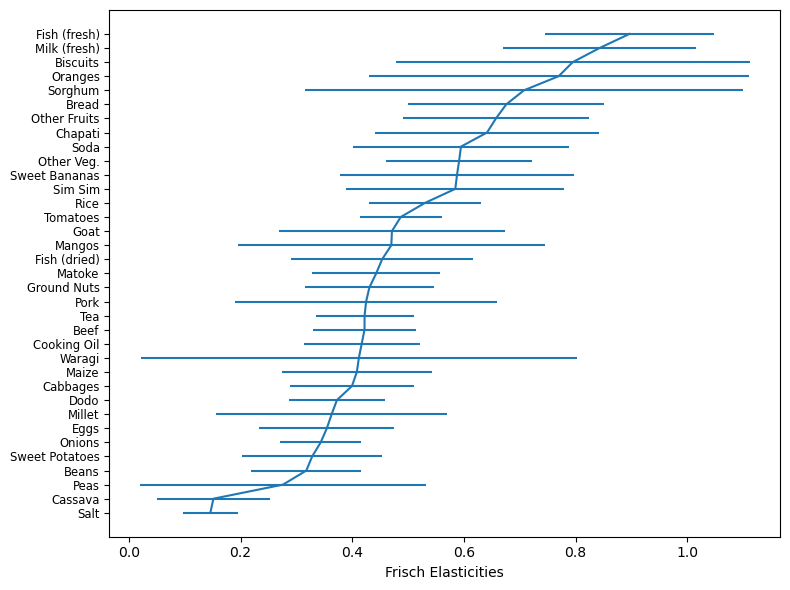

In [47]:
ax = result.graph_beta()

Please choose from the following:
'F 00-03', 'F 14-18', 'F 19-30', 'F 31-50', 'F 51+', 'M 00-03', 'M 14-18', 'M 19-30', 'M 31-50', 'M 51+', 'log HSize', 'children_0413_size'




Please input the population group you would like to visualize (No quotation mark required):  children_0413_size


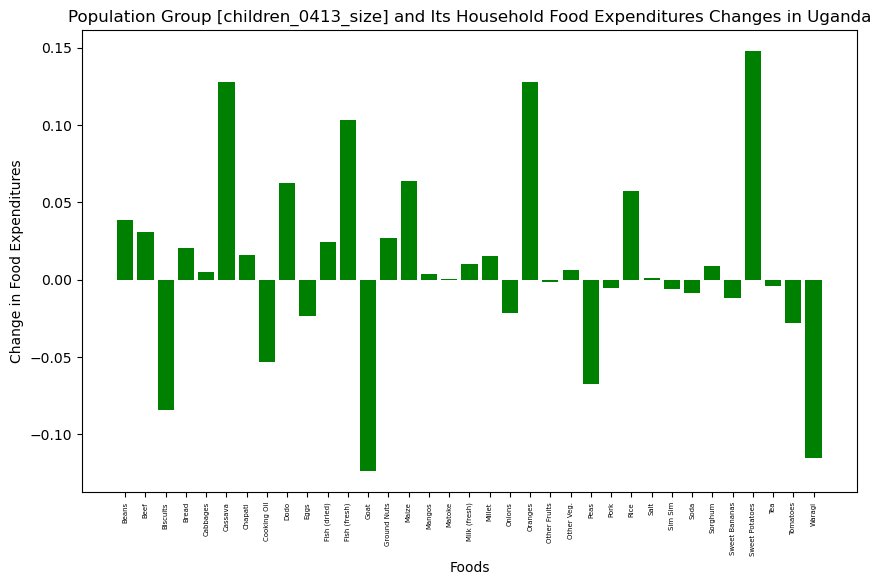

In [48]:
import matplotlib.pyplot as plt
# Gamma is the coefficients of our regression of sub-equation
gamma_df = result.get_gamma()
# Create a bar chart for food elasticities of different population groups
def plot_gamma_table(gamma_table, population_group):
    """
    Ths function is designed to help create a bar chart displaying food expenditure changes with variations of household composition.

    Parameters:
    - gamma_table (DataFrame): The gamma table above.
    - population_group (string): Any population group (string) from the header of gamma table

    Returns:
    - A bar chart described above.
    
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(gamma_table.index, gamma_table[population_group], color='green')
    ax.set_title(f'Population Group [{population_group}] and Its Household Food Expenditures Changes in Uganda')
    ax.set_xlabel('Foods')
    ax.set_ylabel('Change in Food Expenditures')
    plt.xticks(rotation=90, fontsize=5)
    plt.show()

print("Please choose from the following:\n'F 00-03', 'F 14-18', 'F 19-30', 'F 31-50', 'F 51+', 'M 00-03', 'M 14-18', 'M 19-30', 'M 31-50', 'M 51+', 'log HSize', 'children_0413_size'")
print("\n")  
population_input = input('Please input the population group you would like to visualize (No quotation mark required): ')
plot_gamma_table(gamma_df, population_input)

This plot helps us to decide the food in school meal box in our policy analysis.

In [49]:
result.to_pickle('uganda_estimates.rgsn')

#### Budge and Demand

In [50]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean()
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat.head()

,,j,Beans,Beef,Biscuits,Bread,Cabbages,Cassava,Chapati,Cooking Oil,Dodo,Eggs,...,Rice,Salt,Sim Sim,Soda,Sorghum,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi
i,t,m,,,,,,,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,0.966109,0.954852,0.529135,0.850798,0.535620,6.901113,1.470342,0.911783,2.226708,1.392850,...,2.129935,0.207750,0.207190,0.885284,1.349937,1.701003,10.470627,0.020685,2.240118,0.806552
0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,0.607214,0.672272,0.238071,0.546072,0.345704,4.371435,0.946336,0.593078,1.219667,1.161810,...,1.078110,0.158210,0.162620,0.721722,0.709172,1.487601,4.812544,0.013243,1.691567,1.286046
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,0.697274,0.645229,0.126015,0.514873,0.336834,5.557920,0.821073,0.572348,1.289756,1.021713,...,1.061960,0.170171,0.132416,0.563035,0.693901,1.132104,5.371800,0.012889,1.556977,0.906134
1013000201,2019-20,Central,1.082217,1.593470,0.940559,1.571084,0.603654,3.091278,2.443312,0.809574,2.690171,1.965417,...,1.732506,0.146772,0.264052,2.164785,1.392542,3.016939,5.353990,0.033047,3.187524,1.214528
1013000202,2019-20,Central,0.811566,0.646910,0.136108,0.363580,0.269303,3.188751,0.590778,0.388112,1.328123,1.024650,...,0.649729,0.163583,0.074458,0.426173,0.326961,0.890652,3.515201,0.013046,1.119655,0.550773


In [51]:

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,p=pbar,j='Millet'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

Text(0.5, 0, 'Quantities of Beef Demanded')

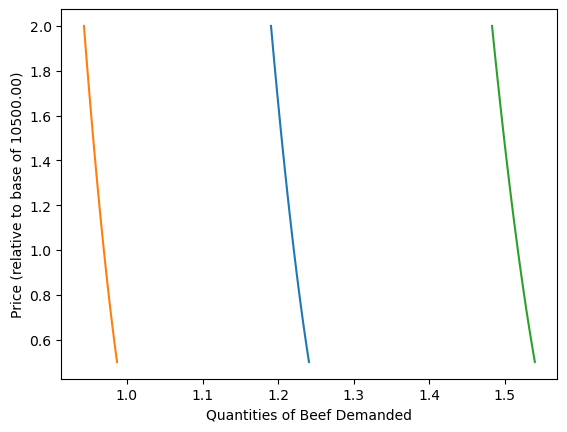

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Beef'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Beef for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Beef for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Beef for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

Text(0.5, 1.0, 'Engel Curves')

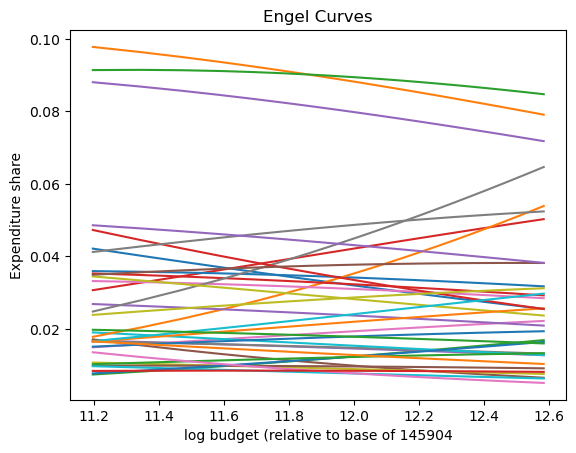

In [53]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

## Nutrition Analysis

#### Mapping Nutrient

In [54]:
fct.head()

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0


In [55]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Beef', 'Biscuits', 'Bread', 'Cabbages', 'Chapati', 'Cooking Oil',
       'Dodo', 'Eggs', 'Mangos', 'Millet', 'Onions', 'Oranges', 'Peas', 'Pork',
       'Sim Sim', 'Soda', 'Sorghum', 'Sweet Bananas', 'Tomatoes', 'Waragi'],
      dtype='object', name='j')


In [56]:
# The @ operator means matrix multiply
N = fct0.T@c0

N.head()  #NB: Uganda quantities are for previous 7 days

i,00c9353d8ebe42faabf5919b81d7fae7,0d0e29faff394154a69562b4527b48b8,0e03e253c35d4333a1ffad2df9d38850,1013000201,1013000202,1013000204,1021000108,1021000109,1021000111,1021000506,...,a98bebba177243668464e31f6d2bb92d,ab5cbcbe0e14402aae73b91c6917a595,acb16f9b068549d8a80a37c9d638742f,ad9b7c4ba614444bb8004eb658693c9f,bfd8253bd59c4f3199fb4b83b9cee7a6,bfdf0d66403440ceab439b1e1c47cdea,c33f6cb57d9849949e08a7350dabb829,d10a687889de469687377204195f3db0,d24fa50d02c041969a42102d8ebdadc9,e07bc322c4884559b4b8ca75c945dd3e
t,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,...,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20
m,Eastern,Eastern,Eastern,Central,Central,Central,Central,Central,Central,Central,...,Western,Eastern,Western,Eastern,Eastern,Eastern,Central,Western,Eastern,Northern
n,,,,,,,,,,,,,,,,,,,,,
Energy,41382.922286,29363.948017,25931.599576,55182.478932,19425.741958,70731.410003,24116.892911,55090.810216,43388.435009,35488.130738,...,99984.717159,38185.620468,44246.756250,84834.293143,76232.025637,49741.149265,27525.319894,28360.791005,61838.523406,47758.390816
Protein,1120.588446,787.146301,730.211373,1725.120449,647.051158,2139.961256,776.699349,1713.804030,1283.302577,1097.013499,...,3005.835430,1019.752738,1300.010641,2487.160585,2108.613687,1276.197667,897.013174,867.911660,1662.335939,1398.781986
Fiber,521.883560,345.444659,309.850651,630.301146,219.981675,786.351949,273.600574,621.283389,474.397454,404.429634,...,1485.076821,464.298327,590.943296,1223.158843,1008.794566,661.185318,308.439082,369.527140,784.440760,661.781655
Folate,9215.545435,5818.976986,5385.600513,11883.440563,4652.043694,13945.428455,5461.417116,11556.002092,8515.612059,7513.121200,...,18440.589529,7467.530995,8330.367355,19128.963709,15628.787484,10659.164193,6145.471025,5725.032248,12639.622674,9172.740146
Calcium,14059.280271,8941.326675,8332.846305,18470.232631,6882.799755,22573.755196,8244.359206,16909.608475,13504.215372,11325.603389,...,29949.441560,11527.326738,13389.421795,31485.682785,24658.597580,15795.327748,9497.947351,8958.097977,19914.927695,13486.883093


In [57]:
def nutrient_demand(x,p):
    c = result.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

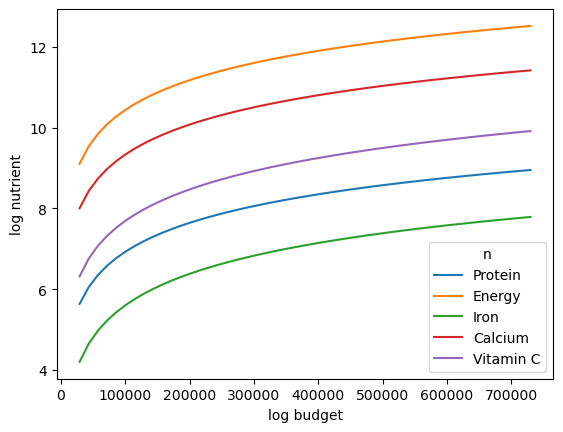

In [58]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

nutrition vary with one food prices

Text(0, 0.5, 'log nutrient')

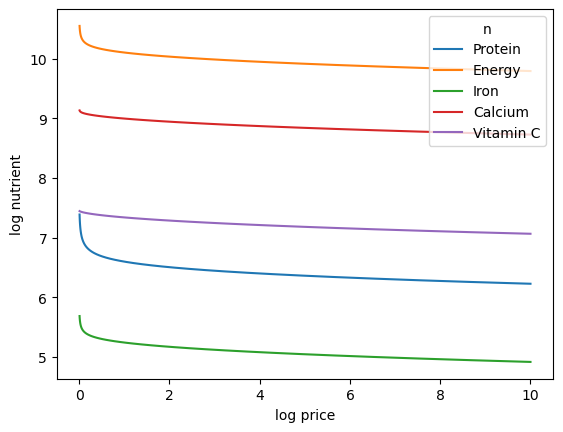

In [59]:
USE_GOOD = 'Beef'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

#### Nutrition Adequecy Ratio

In [61]:
yhat = result.predicted_expenditures()


use = fct.index.intersection(qhat.columns)

nutrients = qhat[use]@fct.loc[use,:]

nutrients.mean()

HH_characteristics = read_sheets(InputFiles['HH Characteristics'][0], sheet=InputFiles['HH Characteristics'][1])

if 'm' not in HH_characteristics.columns:
    HH_characteristics['m'] = 1

HH_characteristics = HH_characteristics.set_index(['i','t','m'])
HH_characteristics.columns.name = 'k' 

HH_characteristics = HH_characteristics.apply(lambda x: pd.to_numeric(x,errors='coerce'))

HH_characteristics = HH_characteristics[rdi.columns.tolist()]

hh_rdi = HH_characteristics@rdi.T

#check recommended weekly intake?
hh_rwi = hh_rdi*7
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio.head()

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,0.501004,0.577921,0.451300,0.537350,0.247959,0.846789,0.512012,0.509419,0.664369,0.697757,0.292919,0.473553,0.701390,1.619605,0.450697
0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,0.676589,0.878511,0.568540,0.755711,0.375686,0.942265,0.703628,0.713939,0.891601,0.976694,0.394745,0.817111,1.118487,2.161949,0.666980
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,0.463064,0.620928,0.395218,0.530601,0.238081,0.663910,0.513567,0.492623,0.624273,0.686263,0.274814,0.574798,0.764712,1.509095,0.447503
1013000201,2019-20,Central,4.927007,5.357517,4.019778,4.244086,2.198837,7.957386,7.551223,4.760480,5.668862,6.583375,2.182954,4.788318,5.210004,9.688701,4.471159
1013000202,2019-20,Central,0.660740,1.100427,0.534455,0.830722,0.307268,0.780477,0.755503,0.759589,1.049870,1.067948,0.464351,1.062083,1.105492,1.981333,0.769509


Please choose from the following:
'Energy', 'Protein', 'Fiber', 'Folate', 'Calcium', 'Carbohydrate','Iron', 'Niacin', 'Riboflavin', 'Thiamin', 'Vitamin A', 'Vitamin B-12', 'Vitamin B-6', 'Vitamin C', 'Zinc']




Please input the nutrition you would like to visualize (No quotation mark required):  Energy


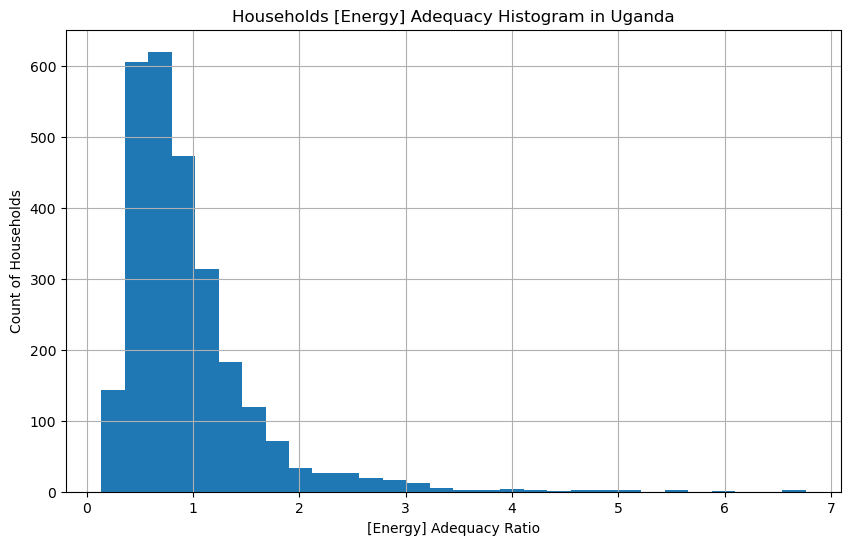

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_nutrition_table(ratio_table, nutrition):
    """
    This function is designed to create a histogram displaying the distribution of nutrition adequacy 
    for households in the Panama Country dataset.

    Parameters:
    - ratio_table (DataFrame): The DataFrame containing the nutrient ratios.
    - nutrition (string): The name of the nutrient column to plot.

    Returns:
    - A histogram for the specified nutrient adequacy among households.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ratio_table[nutrition].hist(ax=ax, bins=30)  # Use ax=ax to plot on the created axes
    plt.title(f'Households [{nutrition}] Adequacy Histogram in Uganda')
    plt.xlabel(f'[{nutrition}] Adequacy Ratio')
    plt.ylabel('Count of Households')
    plt.show()


print("Please choose from the following:\n'Energy', 'Protein', 'Fiber', 'Folate', 'Calcium', 'Carbohydrate','Iron', 'Niacin', 'Riboflavin', 'Thiamin', 'Vitamin A', 'Vitamin B-12', 'Vitamin B-6', 'Vitamin C', 'Zinc']")
print("\n")  
nutrition_input = input('Please input the nutrition you would like to visualize (No quotation mark required): ')
plot_nutrition_table(nutrient_ratio, nutrition_input)